<h2>Main Data Processing - Similar to NN Code</h2>
(except that I only use 1 file of date)

In [1]:
#import multiple files with names as Kickstarter*.csv into pandas dataframe (data used 15 Aug 2019)

from glob import glob
import pandas as pd
from pandas.io.json import json_normalize
import json as json
import numpy as np
from datetime import datetime

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

#just replace the path parts
#glob import all files starting with Kickstarter in the folder (the folder i used is the 15 Aug 2019)

filenames = glob(r"C:\Users\Bi\Downloads\Kickstarter\Kickstarter_2019-08-15T03_20_03_022Z\Kickstarter*.csv")

df_chunks = []
for f in filenames:
    for chunk in pd.read_csv(f, encoding='utf-8', chunksize=100000):
        chunk['launched_at_utc'] = chunk['launched_at'].apply(datetime.utcfromtimestamp)
        chunk['deadline_utc'] = chunk['deadline'].apply(datetime.utcfromtimestamp)
        chunk['created_at_utc'] = chunk['created_at'].apply(datetime.utcfromtimestamp)
        chunk['goal'] = round(chunk['goal'] * chunk['static_usd_rate'], 2)
        x1 = json_normalize(chunk['category'].apply(json.loads)).add_prefix('category_')
        chunk = pd.concat([chunk, x1], axis = 1)
        df = chunk[['disable_communication', 'country', 'currency', 'goal', 'category_id', 'deadline_utc', 'launched_at_utc', 'state']]
        #pick the relevant data and drop all irrelevant data 

        #feature 1: duration of project 
        df['duration'] = (df['deadline_utc'] - df['launched_at_utc']).dt.days

        #feature 2: month of launch
        df['launch_month'] = df['launched_at_utc'].dt.month

        #change state to numerical 
        df['state'] = df['state'].map({'successful': 1, 'failed': 0 })

        #drop columns
        df = df.drop(columns = ['launched_at_utc', 'deadline_utc'])
        df = df.dropna() #drop null rows
        columns = df.columns.tolist()

        columns = columns[-2:] + columns[:-2]
        df_chunks.append(df[columns])
        

df = pd.concat(df_chunks, axis = 0, ignore_index = True).reset_index()
df = df.drop(columns = ['index'])
success_length = df.loc[df['state'] == 1].shape[0]
failure_length = df.shape[0] - success_length
sample_size = min(success_length, failure_length) // 5
print(sample_size)
# Get equal number of success and failure cases
df = pd.concat([df.loc[df['state'] == 1].sample(n=sample_size), df.loc[df['state'] == 0].sample(n=sample_size)])
print(df.columns.tolist())
print(df.shape)

C:\Users\Bi\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Bi\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Bi\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

14828
['duration', 'launch_month', 'disable_communication', 'country', 'currency', 'goal', 'category_id', 'state']
(29656, 8)


In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

print(df.columns.tolist())
print(df.iloc[0].values)
X = np.array(df.iloc[:,:-1].values)
y = np.array(df.iloc[:,-1].values)

label_encoder_month_of_launch = LabelEncoder()
X[:, 1] = label_encoder_month_of_launch.fit_transform(X[:, 1])

label_encoder_disable_com = LabelEncoder()
X[:, 2] = label_encoder_disable_com.fit_transform(X[:, 2])

label_encoder_country = LabelEncoder()
X[:, 3] = label_encoder_country.fit_transform(X[:, 3])

label_encoder_currency = LabelEncoder()
X[:, 4] = label_encoder_currency.fit_transform(X[:, 4])

label_encoder_category = LabelEncoder()
X[:, 6] = label_encoder_category.fit_transform(X[:, 6])

one_hot_encoding = OneHotEncoder(categorical_features=[1, 2, 3, 4, 6])
X = one_hot_encoding.fit_transform(X).toarray()

['duration', 'launch_month', 'disable_communication', 'country', 'currency', 'goal', 'category_id', 'state']
[30 4 False 'CA' 'CAD' 2225.31 307 1.0]


C:\Users\Bi\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\Bi\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:390: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


<h2>SVM Main Model Training</h2>

In [9]:
def svm_train_test_split(X, y, size = 10000):
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = size)
    print(X_train.shape, X_test.shape)

    from sklearn.preprocessing import StandardScaler
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)
    return (X_train, X_test, y_train, y_test)

In [10]:
def evaluate_svm(clf, X_test, y_test): 
    y_pred = clf.predict(X_test)

    from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, f1_score
    accuracy_score = accuracy_score(y_test, y_pred)
    confusion_matrix = confusion_matrix(y_test, y_pred) / len(y_pred)
    roc_score = roc_auc_score(y_test, y_pred)
    f1_score = f1_score(y_test, y_pred)
    print("Accuracy score of: ", accuracy_score)
    print("False Positive rate of: ", confusion_matrix[0, 1])
    print("False Negative rate of: ", confusion_matrix[1, 0])
    print("ROC AUC Score of: ", roc_score)
    print("F1 Score of: ", f1_score)

    import seaborn as sns
    %matplotlib inline
    sns.heatmap(confusion_matrix, annot=True)

In [5]:
#1.1 RBF Kernel
def rbf_kernel(X_train, y_train):
    from sklearn.model_selection import GridSearchCV
    from sklearn.svm import SVC

    parameter_candidates = [
      {'C': [0.01, 1, 10, 100]},
    ]

    clf2 = GridSearchCV(SVC(kernel = 'rbf', class_weight = 'balanced', gamma='auto'), parameter_candidates, cv=5)
    clf2.fit(X_train, y_train)

    best_parameters = clf2.best_params_
    print(best_parameters)
    best_result = clf2.best_score_
    print(best_result)
    
    return clf2

In [11]:
#1.2. Linear Kernel 
def linear_kernel(X_train, y_train): 
    from sklearn.model_selection import GridSearchCV
    from sklearn.svm import LinearSVC

    parameters = [{'C':[0.1, 1, 10, 100]}]
    clf= GridSearchCV(LinearSVC(class_weight = 'balanced'), parameters, cv=5)
    clf.fit(X_train, y_train)

    best_parameters = clf.best_params_
    print(best_parameters)
    best_result = clf.best_score_
    print(best_result)
    return clf

C:\Users\Bi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(10000, 218) (19656, 218)
Training SVM Linear Kernel 0


C:\Users\Bi\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Bi\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Bi\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Bi\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Bi\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

{'C': 0.1}
0.7574
Accuracy score of:  0.7575295075295075
False Positive rate of:  0.08328245828245828
False Negative rate of:  0.15918803418803418
ROC AUC Score of:  0.7572640068228464
F1 Score of:  0.7366268788682583


C:\Users\Bi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(10000, 218) (19656, 218)
Training SVM Linear Kernel 1


C:\Users\Bi\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Bi\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Bi\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Bi\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Bi\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

{'C': 1}
0.762
Accuracy score of:  0.7510683760683761
False Positive rate of:  0.08903133903133903
False Negative rate of:  0.1599002849002849
ROC AUC Score of:  0.7513666940614251
F1 Score of:  0.7333078977489509
(10000, 218) (19656, 218)
Training SVM Linear Kernel 2


C:\Users\Bi\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Bi\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Bi\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Bi\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Bi\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

{'C': 0.1}
0.7622
Accuracy score of:  0.7565628815628815
False Positive rate of:  0.08277370777370778
False Negative rate of:  0.16066341066341067
ROC AUC Score of:  0.756914423109088
F1 Score of:  0.737304419434532
(10000, 218) (19656, 218)
Training SVM RBF Kernel 0
{'C': 1}
0.7406
Accuracy score of:  0.7474053724053724
False Positive rate of:  0.0933048433048433
False Negative rate of:  0.1592897842897843
ROC AUC Score of:  0.7479194885602582
F1 Score of:  0.7318680131770805
(10000, 218) (19656, 218)


C:\Users\Bi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Training SVM RBF Kernel 1
{'C': 1}
0.7505
Accuracy score of:  0.746998371998372
False Positive rate of:  0.08267195767195767
False Negative rate of:  0.17032967032967034
ROC AUC Score of:  0.7463611621900631
F1 Score of:  0.72050806496937
(10000, 218) (19656, 218)
Training SVM RBF Kernel 2


C:\Users\Bi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


{'C': 1}
0.7442
Accuracy score of:  0.7496947496947497
False Positive rate of:  0.07478632478632478
False Negative rate of:  0.1755189255189255
ROC AUC Score of:  0.7506841571594752
F1 Score of:  0.7247398455857671


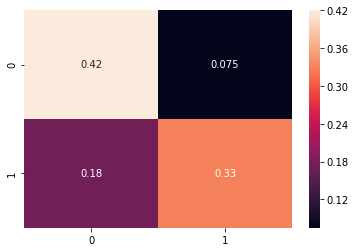

In [7]:
for i in range(3):
    X_train, X_test, y_train, y_test = svm_train_test_split(X, y)
    print("Training SVM Linear Kernel " + str(i))
    clf = linear_kernel(X_train, y_train)
    evaluate_svm(clf, X_test, y_test)
    
for i in range(3):
    X_train, X_test, y_train, y_test = svm_train_test_split(X, y)
    print("Training SVM RBF Kernel " + str(i))
    
    clf = rbf_kernel(X_train, y_train)
    evaluate_svm(clf, X_test, y_test)

Hence, optimal model used for analysing the model is 
<p> from sklearn.svm import LinearSVC
<p> svm = LinearSVC(class_weight='balanced', C=0.1)
<p> svm.fit(X_train, y_train)

<h2>Analyse the model</h2>

<h3>Analyse feature importance</h3>

C:\Users\Bi\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Bi\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Bi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

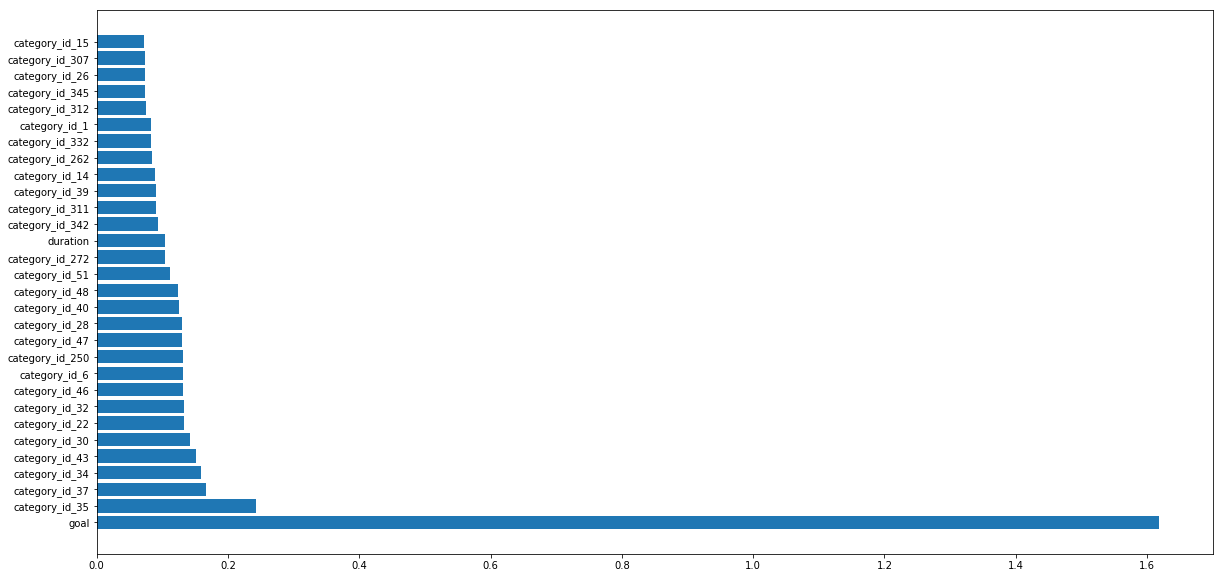

In [46]:
from sklearn.svm import LinearSVC
df = [pd.read_csv(f, encoding='utf-8') for f in filenames]
data = pd.concat(df, axis = 0, ignore_index = True).reset_index()

x1 = json_normalize(data['category'].apply(json.loads)).add_prefix('category_')
data = pd.concat([data, x1], axis = 1)
data.drop_duplicates(subset='id', keep='first', inplace=True)

data['launched_at_utc'] = data['launched_at'].apply(datetime.utcfromtimestamp)
data['deadline_utc'] = data['deadline'].apply(datetime.utcfromtimestamp)

#for goal to be in USD
data['goal'] = round(data['goal'] * data['static_usd_rate'], 2)

def svm_analyse_encode(data):
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    df = data[[ 'currency',
            'disable_communication',
            'goal',
            'state',
            'category_id',
            'launched_at_utc',
            'deadline_utc', 
            'country']]

    df['duration'] = (df['deadline_utc'] - df['launched_at_utc']).dt.days
    df['launch_month'] = df['launched_at_utc'].dt.month

    #BINARY ENCONDING
    df['state'] = df['state'].map({'successful': 1, 'failed': 0 })
    df['disable_communication'] = df['disable_communication'].map({True: 1, False: 0})

    #country 
    for i in ['country', 'launch_month', 'currency', 'category_id']:
        one = pd.get_dummies(df[i], prefix = i)
        df = df.drop(i,axis = 1)
        df = df.join(one)

    #drop columns
    df = df.drop(columns = ['launched_at_utc', 'deadline_utc'])
    df = df.dropna()
    
    X = df.drop(columns = ['state'])  #independent columns
    y = df['state']

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=10000)
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test =  sc_X.fit_transform(X_test)
    features_names = X.columns.tolist()
    return (X_train, X_test, y_train, y_test, features_names)
    
    
X_train, X_test, y_train, y_test, features_names = svm_analyse_encode(data)
from matplotlib import pyplot as plt
def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)
    plt.figure(figsize=(20,10))
    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()
    
# whatever your features are called
svm = LinearSVC(class_weight='balanced', C=0.1)
svm.fit(X_train, y_train)
f_importances(abs(svm.coef_)[0], features_names, top = 30)

<h3>Analyse the performance of the model on US vs non-US and goal > 10000 and goal < 10000 </h3>

<h4>US vs Non-US</h4>

C:\Users\Bi\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Bi\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Bi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

Accuracy score of:  0.7474895865991849
False Positive rate of:  0.05851211537600215
False Negative rate of:  0.193998298024813
ROC AUC Score of:  0.7637744167959932
F1 Score of:  0.7562538370413925


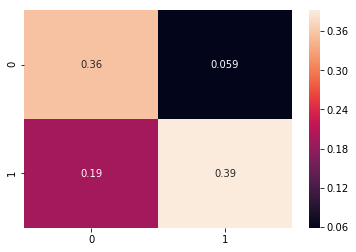

In [43]:
US = data[data['country'] == 'US']
Non_US = data[data['country'] != 'US']

X_train, X_test, y_train, y_test, features_names = svm_analyse_encode(US)
svm = LinearSVC(class_weight='balanced', C=0.1)
svm.fit(X_train, y_train)
evaluate_svm(svm, X_test, y_test)

C:\Users\Bi\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Bi\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Bi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

Accuracy score of:  0.7599603412737757
False Positive rate of:  0.07151616354006314
False Negative rate of:  0.1685234951861612
ROC AUC Score of:  0.7649622167455699
F1 Score of:  0.7508395623442746


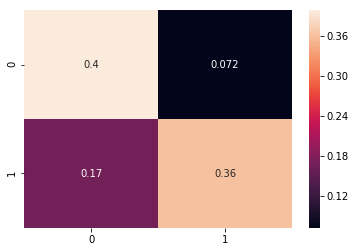

In [47]:
X_train, X_test, y_train, y_test, features_names = svm_analyse_encode(Non_US)
svm = LinearSVC(class_weight='balanced', C=0.1)
svm.fit(X_train, y_train)
evaluate_svm(svm, X_test, y_test)

<h4>Goal below and above 10,000</h4>

C:\Users\Bi\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Bi\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Bi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

Accuracy score of:  0.740324952476597
False Positive rate of:  0.05892005308274452
False Negative rate of:  0.2007549944406585
ROC AUC Score of:  0.761176393063553
F1 Score of:  0.7693128773757747


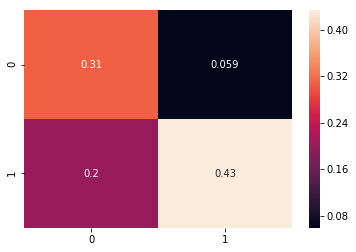

In [49]:
Below_10000 = data[data['goal'] <= 10000]
Above_10000 = data[data['goal'] > 10000]

X_train, X_test, y_train, y_test, features_names = svm_analyse_encode(Below_10000)
svm = LinearSVC(class_weight='balanced', C=0.1)
svm.fit(X_train, y_train)
evaluate_svm(svm, X_test, y_test)

C:\Users\Bi\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Bi\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Bi\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

Accuracy score of:  0.7722566210520839
False Positive rate of:  0.11478224673500183
False Negative rate of:  0.1129611322129143
ROC AUC Score of:  0.7642680577367643
F1 Score of:  0.7201585576369799


C:\Users\Bi\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


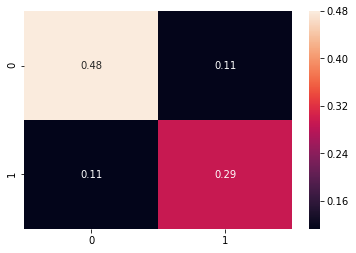

In [50]:
#goal above and below 10,000
X_train, X_test, y_train, y_test, features_names = svm_analyse_encode(Above_10000)
svm = LinearSVC(class_weight='balanced', C=0.1)
svm.fit(X_train, y_train)
evaluate_svm(svm, X_test, y_test)